# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [38]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import NeuroPixel
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [39]:
import urllib.request
file_url = 'http://data.cortexlab.net/singlePhase3/data/rawDataSample.bin'
file_name = "rawDataSample.bin"

urllib.request.urlretrieve(file_url, file_name)

# raw data file (as downloaded above)
data_path = "rawDataSample.bin"

In [44]:
# detection parameters
to_localize = True
cutout_start = 6
cutout_end = 30
threshold = 22
file_directory = 'results/'
file_name = 'ProcessedSpikesNeuropixel'

In [45]:
Probe = NeuroPixel(data_path)
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

## Detecting Spikes

In [46]:
H.DetectFromRaw()

# Sampling rate: 30000
# Localization On
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 385
# Analysing frames: 1800000, Seconds:60.0
# Frames before spike in cutout: 30
# Frames after spike in cutout: 66
# tcuts: 42 55
# tInc: 50000
# Analysing 50000 frames; from -42 to 50055
# Analysing 50000 frames; from 49958 to 100055
# Analysing 50000 frames; from 99958 to 150055
# Analysing 50000 frames; from 149958 to 200055
# Analysing 50000 frames; from 199958 to 250055
# Analysing 50000 frames; from 249958 to 300055
# Analysing 50000 frames; from 299958 to 350055
# Analysing 50000 frames; from 349958 to 400055
# Analysing 50000 frames; from 399958 to 450055
# Analysing 50000 frames; from 449958 to 500055
# Analysing 50000 frames; from 499958 to 550055
# Analysing 50000 frames; from 549958 to 600055
# Analysing 50000 frames; from 599958 to 650055
# Analysing 50000 frames; from 649958 to 700055
# Analysing 50000 frames; from 699958 to 750055
# A

In [47]:
H.LoadDetected()

Detected and read 112625 spikes.


In [48]:
print(H.spikes)

         ch        t  Amplitude       x         y  \
0       337       42       6911  26.820  3365.511   
1        93       46       7290  29.688   951.691   
2         3       64       5915  29.171    47.451   
3       142       67       5476  39.643  1441.158   
4       329       69      12188  37.597  3309.740   
5        15       84       4488  29.527   165.985   
6       336       90       4831  37.132  3390.804   
7        93      101       6650  30.094   948.416   
8       326      118       5166  39.222  3261.493   
9        78      122       6645  40.513   793.626   
10      355      135       4747  42.939  3561.662   
11      334      144       6904  38.691  3369.071   
12       93      153       6161  28.589   954.388   
13      330      188       4425  44.788  3346.918   
14      334      192       6496  41.204  3355.169   
15      358      217       7306  38.551  3585.764   
16      353      217       4755  38.151  3562.547   
17       93      219       6581  30.602   950.

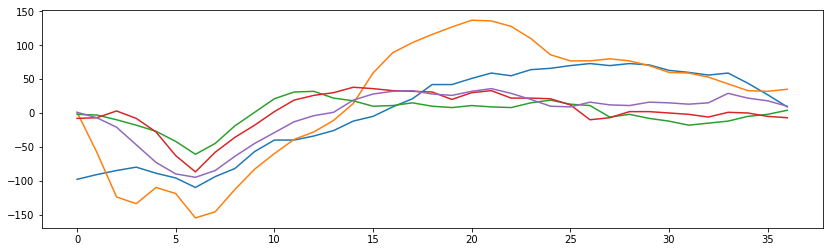

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

In [8]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(112625, 37)


## Scaling data between 0 and 1

In [9]:
# electrode_data = electrode_data_temp[:, :]

In [10]:
# max_val = np.amax(electrode_data)
# min_val = np.amin(electrode_data)
# span = max_val - min_val
# electrode_data = (electrode_data - min_val)/span

In [11]:
print(electrode_data)

[[ -8.   0.   3. ... -25. -37. -45.]
 [  7.   4.  17. ...  11.   2.   5.]
 [  4.  -6.  -9. ...  13.  11.  13.]
 ...
 [  0.  -3.  -3. ...   1.   1.   0.]
 [  6.   3.  -4. ...   7.   6.   5.]
 [-24. -32. -29. ...  21.  18.  13.]]


## Designing the AutoEncoder 

In [12]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(1)
torch.manual_seed(0)

In [13]:
class autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

## Splitting the data into Train and Test

In [14]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (90100, 37)
Test Datasize: (22525, 37)


In [15]:
random.seed(0)

def train_ae(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [16]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [17]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001

ae_1 = autoencoder(length, embedding_size).cuda()
ae_1.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae_1.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_ae(ae_1, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:451.00305, avg:451.00305
epoch [2/5000], loss:521.82007, avg:486.41156
epoch [3/5000], loss:210.92551, avg:394.58289
epoch [4/5000], loss:765.53693, avg:487.32141
epoch [5/5000], loss:1141.71252, avg:618.19965
epoch [6/5000], loss:1813.71204, avg:817.45166
epoch [7/5000], loss:80.47611, avg:712.16949
epoch [8/5000], loss:236.49525, avg:652.71014
epoch [9/5000], loss:483.79144, avg:633.94141
epoch [10/5000], loss:466.01477, avg:617.14874
epoch [11/5000], loss:47.28614, avg:576.77704
epoch [12/5000], loss:97.03410, avg:534.29846
epoch [13/5000], loss:100.69640, avg:523.27557
epoch [14/5000], loss:94.54294, avg:456.17618
epoch [15/5000], loss:248.98813, avg:366.90375
epoch [16/5000], loss:42.80944, avg:189.81348
epoch [17/5000], loss:179.16324, avg:199.68219
epoch [18/5000], loss:182.56172, avg:194.28885
epoch [19/5000], loss:126.22441, avg:158.53214
epoch [20/5000], loss:209.45399, avg:132.87605
epoch [21/5000], loss:97.96968, avg:137.94441
epoch [22/5000], loss:40.2

epoch [179/5000], loss:42.80726, avg:48.52400
epoch [180/5000], loss:91.14106, avg:56.32313
epoch [181/5000], loss:40.25037, avg:58.62617
epoch [182/5000], loss:16.91181, avg:56.99454
epoch [183/5000], loss:21.24839, avg:53.04436
epoch [184/5000], loss:10.75089, avg:39.75356
epoch [185/5000], loss:43.37114, avg:38.90428
epoch [186/5000], loss:65.25996, avg:43.24691
epoch [187/5000], loss:67.53471, avg:43.12522
epoch [188/5000], loss:35.87052, avg:43.51461
epoch [189/5000], loss:172.07870, avg:56.44175
epoch [190/5000], loss:11.05039, avg:48.43269
epoch [191/5000], loss:22.70513, avg:46.67816
epoch [192/5000], loss:35.75927, avg:48.56291
epoch [193/5000], loss:199.58521, avg:66.39660
epoch [194/5000], loss:28.92867, avg:68.21437
epoch [195/5000], loss:22.18053, avg:66.09531
epoch [196/5000], loss:38.48613, avg:63.41793
epoch [197/5000], loss:27.01597, avg:59.36605
epoch [198/5000], loss:19.31643, avg:57.71064
epoch [199/5000], loss:52.75200, avg:45.77797
epoch [200/5000], loss:16.29612,

epoch [358/5000], loss:17.84974, avg:32.48712
epoch [359/5000], loss:91.96935, avg:38.57605
epoch [360/5000], loss:11.93634, avg:35.47224
epoch [361/5000], loss:36.99068, avg:33.14158
epoch [362/5000], loss:15.39454, avg:32.26892
epoch [363/5000], loss:27.11004, avg:30.10292
epoch [364/5000], loss:26.83822, avg:30.83004
epoch [365/5000], loss:17.24716, avg:31.05081
epoch [366/5000], loss:22.75762, avg:30.87252
epoch [367/5000], loss:92.17435, avg:36.02681
epoch [368/5000], loss:69.23240, avg:41.16507
epoch [369/5000], loss:13.49477, avg:33.31761
epoch [370/5000], loss:19.62113, avg:34.08609
epoch [371/5000], loss:14.49969, avg:31.83699
epoch [372/5000], loss:29.20969, avg:33.21850
epoch [373/5000], loss:55.82613, avg:36.09012
epoch [374/5000], loss:29.44615, avg:36.35091
epoch [375/5000], loss:22.87913, avg:36.91410
epoch [376/5000], loss:56.08253, avg:40.24659
epoch [377/5000], loss:23.80756, avg:33.40992
epoch [378/5000], loss:25.96839, avg:29.08352
epoch [379/5000], loss:9.35270, av

epoch [537/5000], loss:23.82685, avg:23.50184
epoch [538/5000], loss:16.23987, avg:23.19360
epoch [539/5000], loss:8.53782, avg:18.68468
epoch [540/5000], loss:34.11600, avg:20.19477
epoch [541/5000], loss:26.48615, avg:21.45069
epoch [542/5000], loss:143.07846, avg:31.65547
epoch [543/5000], loss:45.40301, avg:34.76056
epoch [544/5000], loss:12.54377, avg:33.78649
epoch [545/5000], loss:29.55075, avg:36.22292
epoch [546/5000], loss:13.51205, avg:35.32948
epoch [547/5000], loss:16.19491, avg:34.56628
epoch [548/5000], loss:20.86443, avg:35.02874
epoch [549/5000], loss:12.82423, avg:35.45738
epoch [550/5000], loss:44.84703, avg:36.53048
epoch [551/5000], loss:24.89160, avg:36.37103
epoch [552/5000], loss:22.24434, avg:24.28761
epoch [553/5000], loss:96.97723, avg:29.44504
epoch [554/5000], loss:38.23214, avg:32.01387
epoch [555/5000], loss:11.61018, avg:30.21982
epoch [556/5000], loss:81.86716, avg:37.05532
epoch [557/5000], loss:88.33346, avg:44.26918
epoch [558/5000], loss:10.41841, a

epoch [716/5000], loss:32.14829, avg:34.75573
epoch [717/5000], loss:19.21710, avg:35.06186
epoch [718/5000], loss:11.08379, avg:34.10847
epoch [719/5000], loss:9.52256, avg:33.12205
epoch [720/5000], loss:123.61697, avg:43.76270
epoch [721/5000], loss:46.58499, avg:45.96990
epoch [722/5000], loss:8.10275, avg:38.29847
epoch [723/5000], loss:8.69093, avg:33.11090
epoch [724/5000], loss:8.29558, avg:29.78052
epoch [725/5000], loss:37.58221, avg:30.48452
epoch [726/5000], loss:15.02496, avg:28.77219
epoch [727/5000], loss:29.26528, avg:29.77701
epoch [728/5000], loss:17.67421, avg:30.43605
epoch [729/5000], loss:7.16262, avg:30.20006
epoch [730/5000], loss:57.64168, avg:23.60252
epoch [731/5000], loss:36.22388, avg:22.56641
epoch [732/5000], loss:11.37135, avg:22.89327
epoch [733/5000], loss:8.95355, avg:22.91954
epoch [734/5000], loss:18.79084, avg:23.96906
epoch [735/5000], loss:10.98430, avg:21.30927
epoch [736/5000], loss:16.61741, avg:21.46851
epoch [737/5000], loss:23.77997, avg:20

epoch [895/5000], loss:13.65855, avg:17.69662
epoch [896/5000], loss:26.65050, avg:18.28907
epoch [897/5000], loss:13.62625, avg:17.57180
epoch [898/5000], loss:27.83069, avg:19.06105
epoch [899/5000], loss:38.85409, avg:21.18017
epoch [900/5000], loss:31.86556, avg:21.60337
epoch [901/5000], loss:38.13441, avg:23.57934
epoch [902/5000], loss:30.81995, avg:24.53687
epoch [903/5000], loss:127.78532, avg:36.45115
epoch [904/5000], loss:14.56483, avg:36.37901
epoch [905/5000], loss:36.37148, avg:38.65031
epoch [906/5000], loss:43.50859, avg:40.33612
epoch [907/5000], loss:18.49665, avg:40.82316
epoch [908/5000], loss:28.58807, avg:40.89890
epoch [909/5000], loss:39.46220, avg:40.95971
epoch [910/5000], loss:129.23715, avg:50.69687
epoch [911/5000], loss:23.79961, avg:49.26339
epoch [912/5000], loss:30.91379, avg:49.27277
epoch [913/5000], loss:17.92012, avg:38.28625
epoch [914/5000], loss:12.75702, avg:38.10547
epoch [915/5000], loss:53.68574, avg:39.83689
epoch [916/5000], loss:23.22315,

epoch [1072/5000], loss:9.18954, avg:14.54219
epoch [1073/5000], loss:15.32470, avg:14.43223
epoch [1074/5000], loss:52.36195, avg:17.22698
epoch [1075/5000], loss:30.57364, avg:19.39142
epoch [1076/5000], loss:9.37340, avg:19.33175
epoch [1077/5000], loss:25.17066, avg:20.13755
epoch [1078/5000], loss:33.25570, avg:22.57699
epoch [1079/5000], loss:54.66678, avg:25.38987
epoch [1080/5000], loss:19.15993, avg:26.39697
epoch [1081/5000], loss:24.11227, avg:27.31886
epoch [1082/5000], loss:41.75695, avg:30.57560
epoch [1083/5000], loss:46.14927, avg:33.65805
epoch [1084/5000], loss:22.77344, avg:30.69920
epoch [1085/5000], loss:30.04954, avg:30.64679
epoch [1086/5000], loss:12.57264, avg:30.96671
epoch [1087/5000], loss:11.34407, avg:29.58405
epoch [1088/5000], loss:9.63146, avg:27.22164
epoch [1089/5000], loss:24.17700, avg:24.17266
epoch [1090/5000], loss:7.88534, avg:23.04520
epoch [1091/5000], loss:23.81151, avg:23.01512
epoch [1092/5000], loss:19.28181, avg:20.76761
epoch [1093/5000]

epoch [1247/5000], loss:14.84445, avg:26.63002
epoch [1248/5000], loss:45.90342, avg:28.43751
epoch [1249/5000], loss:23.75909, avg:28.99302
epoch [1250/5000], loss:9.63467, avg:25.96165
epoch [1251/5000], loss:15.62049, avg:25.89281
epoch [1252/5000], loss:20.28604, avg:23.47710
epoch [1253/5000], loss:18.61730, avg:20.82236
epoch [1254/5000], loss:18.69724, avg:19.31837
epoch [1255/5000], loss:90.55306, avg:27.02573
epoch [1256/5000], loss:10.32899, avg:26.82448
epoch [1257/5000], loss:90.44659, avg:34.38469
epoch [1258/5000], loss:33.04241, avg:33.09859
epoch [1259/5000], loss:63.14977, avg:37.03766
epoch [1260/5000], loss:25.69270, avg:38.64346
epoch [1261/5000], loss:28.66269, avg:39.94768
epoch [1262/5000], loss:23.88285, avg:40.30736
epoch [1263/5000], loss:15.91071, avg:40.03670
epoch [1264/5000], loss:13.33528, avg:39.50050
epoch [1265/5000], loss:11.57305, avg:31.60250
epoch [1266/5000], loss:12.05152, avg:31.77476
epoch [1267/5000], loss:16.95468, avg:24.42557
epoch [1268/50

epoch [1422/5000], loss:22.67946, avg:30.00077
epoch [1423/5000], loss:8.38408, avg:29.46056
epoch [1424/5000], loss:70.03570, avg:33.18026
epoch [1425/5000], loss:7.66973, avg:32.61926
epoch [1426/5000], loss:21.49734, avg:29.95200
epoch [1427/5000], loss:25.12465, avg:29.63447
epoch [1428/5000], loss:12.26168, avg:27.54688
epoch [1429/5000], loss:18.93134, avg:27.92335
epoch [1430/5000], loss:24.89741, avg:22.10941
epoch [1431/5000], loss:14.92175, avg:22.64031
epoch [1432/5000], loss:5.72678, avg:20.94505
epoch [1433/5000], loss:18.17154, avg:21.92379
epoch [1434/5000], loss:29.51881, avg:17.87210
epoch [1435/5000], loss:13.65297, avg:18.47043
epoch [1436/5000], loss:7.89920, avg:17.11061
epoch [1437/5000], loss:10.91280, avg:15.68943
epoch [1438/5000], loss:52.88386, avg:19.75165
epoch [1439/5000], loss:14.99259, avg:19.35777
epoch [1440/5000], loss:74.90600, avg:24.35863
epoch [1441/5000], loss:8.42501, avg:23.70896
epoch [1442/5000], loss:15.92711, avg:24.72899
epoch [1443/5000],

epoch [1597/5000], loss:19.17097, avg:22.14266
epoch [1598/5000], loss:39.88428, avg:22.01343
epoch [1599/5000], loss:16.81987, avg:22.58346
epoch [1600/5000], loss:9.32324, avg:21.46729
epoch [1601/5000], loss:32.31215, avg:23.51374
epoch [1602/5000], loss:15.38801, avg:21.70349
epoch [1603/5000], loss:12.21259, avg:20.48641
epoch [1604/5000], loss:9.12144, avg:19.41747
epoch [1605/5000], loss:21.73850, avg:19.19220
epoch [1606/5000], loss:14.21151, avg:19.01826
epoch [1607/5000], loss:11.43123, avg:18.24428
epoch [1608/5000], loss:65.20189, avg:20.77604
epoch [1609/5000], loss:89.93511, avg:28.08757
epoch [1610/5000], loss:19.15348, avg:29.07059
epoch [1611/5000], loss:41.77429, avg:30.01681
epoch [1612/5000], loss:21.80823, avg:30.65883
epoch [1613/5000], loss:16.26785, avg:31.06435
epoch [1614/5000], loss:16.57287, avg:31.80950
epoch [1615/5000], loss:12.32747, avg:30.86840
epoch [1616/5000], loss:10.66672, avg:30.51392
epoch [1617/5000], loss:16.74215, avg:31.04501
epoch [1618/500

epoch [1772/5000], loss:15.06943, avg:21.31835
epoch [1773/5000], loss:19.12287, avg:21.57047
epoch [1774/5000], loss:17.08780, avg:21.91935
epoch [1775/5000], loss:9.46577, avg:20.38470
epoch [1776/5000], loss:58.26548, avg:24.55408
epoch [1777/5000], loss:19.17515, avg:24.99733
epoch [1778/5000], loss:9.28402, avg:24.45937
epoch [1779/5000], loss:34.12642, avg:22.30627
epoch [1780/5000], loss:12.24402, avg:21.33740
epoch [1781/5000], loss:45.99298, avg:23.98339
epoch [1782/5000], loss:7.02800, avg:23.17925
epoch [1783/5000], loss:26.36079, avg:23.90304
epoch [1784/5000], loss:39.75548, avg:26.16981
epoch [1785/5000], loss:22.68208, avg:27.49144
epoch [1786/5000], loss:16.49831, avg:23.31473
epoch [1787/5000], loss:36.97508, avg:25.09472
epoch [1788/5000], loss:12.09378, avg:25.37569
epoch [1789/5000], loss:14.67534, avg:23.43059
epoch [1790/5000], loss:23.08724, avg:24.51491
epoch [1791/5000], loss:7.48590, avg:20.66420
epoch [1792/5000], loss:34.69950, avg:23.43135
epoch [1793/5000]

epoch [1947/5000], loss:27.16586, avg:19.51237
epoch [1948/5000], loss:83.71581, avg:26.14251
epoch [1949/5000], loss:9.25922, avg:25.96988
epoch [1950/5000], loss:8.22251, avg:25.61016
epoch [1951/5000], loss:33.42852, avg:27.31566
epoch [1952/5000], loss:37.51302, avg:27.56872
epoch [1953/5000], loss:15.50703, avg:27.09591
epoch [1954/5000], loss:18.23557, avg:27.99835
epoch [1955/5000], loss:18.77113, avg:26.14121
epoch [1956/5000], loss:9.10747, avg:26.09262
epoch [1957/5000], loss:20.36394, avg:25.41242
epoch [1958/5000], loss:8.43752, avg:17.88459
epoch [1959/5000], loss:8.35186, avg:17.79386
epoch [1960/5000], loss:20.65619, avg:19.03722
epoch [1961/5000], loss:41.08586, avg:19.80296
epoch [1962/5000], loss:7.98123, avg:16.84978
epoch [1963/5000], loss:18.71074, avg:17.17015
epoch [1964/5000], loss:40.30938, avg:19.37753
epoch [1965/5000], loss:15.94298, avg:19.09472
epoch [1966/5000], loss:17.74674, avg:19.95865
epoch [1967/5000], loss:12.49593, avg:19.17184
epoch [1968/5000], 

epoch [2122/5000], loss:33.05244, avg:18.75513
epoch [2123/5000], loss:132.94458, avg:30.88713
epoch [2124/5000], loss:46.37237, avg:32.42566
epoch [2125/5000], loss:27.67299, avg:33.71101
epoch [2126/5000], loss:13.71500, avg:33.60746
epoch [2127/5000], loss:36.47451, avg:35.56197
epoch [2128/5000], loss:14.97605, avg:35.17608
epoch [2129/5000], loss:13.95834, avg:35.30036
epoch [2130/5000], loss:46.98747, avg:37.77472
epoch [2131/5000], loss:17.86598, avg:38.40197
epoch [2132/5000], loss:5.75418, avg:35.67215
epoch [2133/5000], loss:93.54100, avg:31.73179
epoch [2134/5000], loss:18.54770, avg:28.94932
epoch [2135/5000], loss:32.50296, avg:29.43232
epoch [2136/5000], loss:11.00913, avg:29.16173
epoch [2137/5000], loss:24.30349, avg:27.94463
epoch [2138/5000], loss:17.39410, avg:28.18644
epoch [2139/5000], loss:11.95921, avg:27.98652
epoch [2140/5000], loss:14.90887, avg:24.77866
epoch [2141/5000], loss:17.05110, avg:24.69717
epoch [2142/5000], loss:25.83186, avg:26.70494
epoch [2143/5

epoch [2297/5000], loss:35.25488, avg:24.72800
epoch [2298/5000], loss:17.75533, avg:23.57269
epoch [2299/5000], loss:22.51500, avg:21.45975
epoch [2300/5000], loss:18.49273, avg:20.03955
epoch [2301/5000], loss:14.22517, avg:18.73736
epoch [2302/5000], loss:10.47827, avg:18.04995
epoch [2303/5000], loss:21.17540, avg:18.80723
epoch [2304/5000], loss:17.64109, avg:17.97202
epoch [2305/5000], loss:13.00856, avg:17.90412
epoch [2306/5000], loss:12.32500, avg:18.28714
epoch [2307/5000], loss:19.78744, avg:16.74040
epoch [2308/5000], loss:11.66531, avg:16.13140
epoch [2309/5000], loss:7.69144, avg:14.64904
epoch [2310/5000], loss:12.91126, avg:14.09089
epoch [2311/5000], loss:13.23003, avg:13.99138
epoch [2312/5000], loss:16.44485, avg:14.58804
epoch [2313/5000], loss:20.00389, avg:14.47089
epoch [2314/5000], loss:94.10541, avg:22.11732
epoch [2315/5000], loss:8.23464, avg:21.63993
epoch [2316/5000], loss:10.95409, avg:21.50284
epoch [2317/5000], loss:19.47170, avg:21.47126
epoch [2318/500

epoch [2472/5000], loss:18.55984, avg:36.84578
epoch [2473/5000], loss:8.92233, avg:28.39244
epoch [2474/5000], loss:57.52007, avg:33.23730
epoch [2475/5000], loss:15.11145, avg:33.10094
epoch [2476/5000], loss:27.32648, avg:33.36232
epoch [2477/5000], loss:37.28720, avg:34.54823
epoch [2478/5000], loss:284.97000, avg:52.73370
epoch [2479/5000], loss:10.83426, avg:51.62930
epoch [2480/5000], loss:12.67278, avg:50.28762
epoch [2481/5000], loss:42.80088, avg:51.60053
epoch [2482/5000], loss:10.62787, avg:50.80733
epoch [2483/5000], loss:19.10645, avg:51.82574
epoch [2484/5000], loss:33.38209, avg:49.41195
epoch [2485/5000], loss:15.27436, avg:49.42823
epoch [2486/5000], loss:10.33362, avg:47.72895
epoch [2487/5000], loss:15.12257, avg:45.51249
epoch [2488/5000], loss:27.54675, avg:19.77016
epoch [2489/5000], loss:21.96814, avg:20.88355
epoch [2490/5000], loss:29.41955, avg:22.55823
epoch [2491/5000], loss:30.45351, avg:21.32349
epoch [2492/5000], loss:45.76252, avg:24.83696
epoch [2493/5

epoch [2647/5000], loss:39.63903, avg:28.35160
epoch [2648/5000], loss:19.81499, avg:29.22435
epoch [2649/5000], loss:18.66852, avg:29.48236
epoch [2650/5000], loss:15.68048, avg:19.25797
epoch [2651/5000], loss:15.87190, avg:19.46147
epoch [2652/5000], loss:6.23539, avg:18.26952
epoch [2653/5000], loss:33.73385, avg:19.65487
epoch [2654/5000], loss:20.63070, avg:20.33776
epoch [2655/5000], loss:7.52904, avg:18.89454
epoch [2656/5000], loss:12.87799, avg:19.06819
epoch [2657/5000], loss:16.29451, avg:16.73374
epoch [2658/5000], loss:14.19156, avg:16.17139
epoch [2659/5000], loss:16.45404, avg:15.94995
epoch [2660/5000], loss:10.97734, avg:15.47963
epoch [2661/5000], loss:134.08995, avg:27.30144
epoch [2662/5000], loss:18.67426, avg:28.54532
epoch [2663/5000], loss:27.49160, avg:27.92110
epoch [2664/5000], loss:19.15021, avg:27.77305
epoch [2665/5000], loss:142.58377, avg:41.27853
epoch [2666/5000], loss:15.30163, avg:41.52089
epoch [2667/5000], loss:31.77147, avg:43.06858
epoch [2668/5

epoch [2822/5000], loss:34.83600, avg:28.30877
epoch [2823/5000], loss:23.61091, avg:26.79502
epoch [2824/5000], loss:17.38704, avg:24.76823
epoch [2825/5000], loss:26.16724, avg:26.40932
epoch [2826/5000], loss:16.84765, avg:26.34279
epoch [2827/5000], loss:17.23888, avg:22.75558
epoch [2828/5000], loss:16.14819, avg:21.57195
epoch [2829/5000], loss:47.02662, avg:23.66606
epoch [2830/5000], loss:16.09212, avg:23.11189
epoch [2831/5000], loss:18.85772, avg:23.42124
epoch [2832/5000], loss:7.29137, avg:20.66677
epoch [2833/5000], loss:14.67916, avg:19.77360
epoch [2834/5000], loss:36.00298, avg:21.63519
epoch [2835/5000], loss:56.27077, avg:24.64555
epoch [2836/5000], loss:33.60526, avg:26.32131
epoch [2837/5000], loss:18.43320, avg:26.44074
epoch [2838/5000], loss:15.24133, avg:26.35005
epoch [2839/5000], loss:30.19215, avg:24.66661
epoch [2840/5000], loss:30.46455, avg:26.10385
epoch [2841/5000], loss:17.07121, avg:25.92520
epoch [2842/5000], loss:60.16393, avg:31.21245
epoch [2843/50

epoch [2997/5000], loss:18.60570, avg:23.82985
epoch [2998/5000], loss:41.97514, avg:26.73872
epoch [2999/5000], loss:33.77558, avg:25.60395
epoch [3000/5000], loss:12.51425, avg:25.37512
epoch [3001/5000], loss:33.97206, avg:25.49272
epoch [3002/5000], loss:38.30415, avg:25.46809
epoch [3003/5000], loss:65.05391, avg:30.44475
epoch [3004/5000], loss:9.90999, avg:29.51148
epoch [3005/5000], loss:51.74869, avg:32.58677
epoch [3006/5000], loss:14.44687, avg:32.03064
epoch [3007/5000], loss:22.56908, avg:32.42697
epoch [3008/5000], loss:10.11119, avg:29.24058
epoch [3009/5000], loss:14.68373, avg:27.33139
epoch [3010/5000], loss:37.59259, avg:29.83922
epoch [3011/5000], loss:13.48011, avg:27.79003
epoch [3012/5000], loss:14.59981, avg:25.41960
epoch [3013/5000], loss:19.25738, avg:20.83994
epoch [3014/5000], loss:37.19723, avg:23.56867
epoch [3015/5000], loss:21.94327, avg:20.58813
epoch [3016/5000], loss:13.31362, avg:20.47480
epoch [3017/5000], loss:51.55301, avg:23.37319
epoch [3018/50

epoch [3172/5000], loss:13.28017, avg:21.86841
epoch [3173/5000], loss:32.89314, avg:22.37104
epoch [3174/5000], loss:16.23543, avg:22.35554
epoch [3175/5000], loss:26.74026, avg:23.44121
epoch [3176/5000], loss:30.15645, avg:23.54988
epoch [3177/5000], loss:20.42628, avg:21.34842
epoch [3178/5000], loss:19.18066, avg:21.79851
epoch [3179/5000], loss:8.23551, avg:21.57710
epoch [3180/5000], loss:25.14544, avg:20.52025
epoch [3181/5000], loss:21.47449, avg:21.37678
epoch [3182/5000], loss:102.30740, avg:30.27950
epoch [3183/5000], loss:14.14365, avg:28.40456
epoch [3184/5000], loss:9.05463, avg:27.68648
epoch [3185/5000], loss:8.35672, avg:25.84812
epoch [3186/5000], loss:14.26009, avg:24.25849
epoch [3187/5000], loss:15.71179, avg:23.78704
epoch [3188/5000], loss:28.62530, avg:24.73150
epoch [3189/5000], loss:19.36032, avg:25.84398
epoch [3190/5000], loss:9.69050, avg:24.29849
epoch [3191/5000], loss:8.84856, avg:23.03589
epoch [3192/5000], loss:40.90927, avg:16.89608
epoch [3193/5000]

epoch [3347/5000], loss:30.87375, avg:39.89125
epoch [3348/5000], loss:38.42668, avg:36.42591
epoch [3349/5000], loss:12.86076, avg:34.92414
epoch [3350/5000], loss:36.15111, avg:23.42841
epoch [3351/5000], loss:31.66310, avg:25.50450
epoch [3352/5000], loss:39.88459, avg:24.74699
epoch [3353/5000], loss:14.74051, avg:25.19964
epoch [3354/5000], loss:36.31363, avg:26.70740
epoch [3355/5000], loss:29.39860, avg:28.47487
epoch [3356/5000], loss:13.22412, avg:28.35369
epoch [3357/5000], loss:37.20170, avg:28.98648
epoch [3358/5000], loss:36.56918, avg:28.80073
epoch [3359/5000], loss:10.01137, avg:28.51579
epoch [3360/5000], loss:198.16612, avg:44.71729
epoch [3361/5000], loss:18.14562, avg:43.36555
epoch [3362/5000], loss:23.14637, avg:41.69172
epoch [3363/5000], loss:5.57696, avg:40.77537
epoch [3364/5000], loss:13.50507, avg:38.49451
epoch [3365/5000], loss:22.00968, avg:37.75562
epoch [3366/5000], loss:9.11456, avg:37.34466
epoch [3367/5000], loss:16.62516, avg:35.28701
epoch [3368/50

epoch [3522/5000], loss:15.48382, avg:38.72845
epoch [3523/5000], loss:7.56931, avg:37.90789
epoch [3524/5000], loss:74.97822, avg:41.69195
epoch [3525/5000], loss:8.81202, avg:29.26197
epoch [3526/5000], loss:14.05743, avg:27.21065
epoch [3527/5000], loss:34.26426, avg:29.42465
epoch [3528/5000], loss:11.12098, avg:29.17306
epoch [3529/5000], loss:36.84603, avg:26.78980
epoch [3530/5000], loss:8.10554, avg:26.40043
epoch [3531/5000], loss:52.41163, avg:26.36492
epoch [3532/5000], loss:42.63967, avg:29.08051
epoch [3533/5000], loss:40.64608, avg:32.38819
epoch [3534/5000], loss:11.85290, avg:26.07565
epoch [3535/5000], loss:23.64934, avg:27.55939
epoch [3536/5000], loss:19.35360, avg:28.08900
epoch [3537/5000], loss:29.79624, avg:27.64220
epoch [3538/5000], loss:12.40669, avg:27.77077
epoch [3539/5000], loss:35.42860, avg:27.62903
epoch [3540/5000], loss:42.26273, avg:31.04475
epoch [3541/5000], loss:13.33506, avg:27.13709
epoch [3542/5000], loss:17.89290, avg:24.66241
epoch [3543/5000

epoch [3697/5000], loss:11.23925, avg:56.59740
epoch [3698/5000], loss:50.25381, avg:60.31830
epoch [3699/5000], loss:9.89464, avg:60.26097
epoch [3700/5000], loss:46.52184, avg:64.02877
epoch [3701/5000], loss:26.62955, avg:25.23946
epoch [3702/5000], loss:9.32844, avg:25.11576
epoch [3703/5000], loss:20.80392, avg:26.15191
epoch [3704/5000], loss:29.47644, avg:25.85348
epoch [3705/5000], loss:10.02509, avg:25.84985
epoch [3706/5000], loss:34.96659, avg:24.91396
epoch [3707/5000], loss:46.25935, avg:28.41596
epoch [3708/5000], loss:14.24870, avg:24.81546
epoch [3709/5000], loss:9.46936, avg:24.77293
epoch [3710/5000], loss:37.14870, avg:23.83562
epoch [3711/5000], loss:10.43735, avg:22.21639
epoch [3712/5000], loss:15.43150, avg:22.82670
epoch [3713/5000], loss:14.36056, avg:22.18236
epoch [3714/5000], loss:14.51760, avg:20.68648
epoch [3715/5000], loss:13.95843, avg:21.07981
epoch [3716/5000], loss:16.91763, avg:19.27492
epoch [3717/5000], loss:18.52512, avg:16.50150
epoch [3718/5000

epoch [3872/5000], loss:62.43139, avg:29.75451
epoch [3873/5000], loss:21.79033, avg:30.62650
epoch [3874/5000], loss:95.34957, avg:38.67611
epoch [3875/5000], loss:29.24837, avg:38.20092
epoch [3876/5000], loss:14.74128, avg:38.62463
epoch [3877/5000], loss:56.99549, avg:43.30024
epoch [3878/5000], loss:34.25933, avg:44.66435
epoch [3879/5000], loss:29.09603, avg:44.25163
epoch [3880/5000], loss:74.33421, avg:45.60524
epoch [3881/5000], loss:150.67865, avg:56.89247
epoch [3882/5000], loss:16.91532, avg:52.34086
epoch [3883/5000], loss:37.70203, avg:53.93203
epoch [3884/5000], loss:34.46852, avg:47.84392
epoch [3885/5000], loss:13.74899, avg:46.29398
epoch [3886/5000], loss:15.60594, avg:46.38045
epoch [3887/5000], loss:32.13572, avg:43.89447
epoch [3888/5000], loss:13.44425, avg:41.81296
epoch [3889/5000], loss:21.74121, avg:41.07748
epoch [3890/5000], loss:16.51825, avg:35.29589
epoch [3891/5000], loss:6.08465, avg:20.83649
epoch [3892/5000], loss:24.91413, avg:21.63637
epoch [3893/5

epoch [4047/5000], loss:14.61020, avg:28.19405
epoch [4048/5000], loss:10.22439, avg:21.03573
epoch [4049/5000], loss:12.80245, avg:20.17458
epoch [4050/5000], loss:18.15054, avg:20.37839
epoch [4051/5000], loss:6.85601, avg:19.47397
epoch [4052/5000], loss:49.15477, avg:23.42786
epoch [4053/5000], loss:19.99226, avg:22.81231
epoch [4054/5000], loss:12.73276, avg:21.26361
epoch [4055/5000], loss:9.72135, avg:16.78877
epoch [4056/5000], loss:9.78506, avg:16.40298
epoch [4057/5000], loss:11.94433, avg:16.13639
epoch [4058/5000], loss:21.86210, avg:17.30016
epoch [4059/5000], loss:34.04415, avg:19.42433
epoch [4060/5000], loss:7.52283, avg:18.36156
epoch [4061/5000], loss:23.32291, avg:20.00825
epoch [4062/5000], loss:11.86403, avg:16.27918
epoch [4063/5000], loss:74.52624, avg:21.73257
epoch [4064/5000], loss:21.64741, avg:22.62404
epoch [4065/5000], loss:25.19038, avg:24.17094
epoch [4066/5000], loss:17.75954, avg:24.96839
epoch [4067/5000], loss:17.70535, avg:25.54449
epoch [4068/5000]

epoch [4222/5000], loss:17.10360, avg:18.00888
epoch [4223/5000], loss:24.95048, avg:18.76160
epoch [4224/5000], loss:30.35411, avg:20.22616
epoch [4225/5000], loss:10.80155, avg:19.01452
epoch [4226/5000], loss:23.70642, avg:20.31516
epoch [4227/5000], loss:11.52648, avg:19.97722
epoch [4228/5000], loss:20.83458, avg:19.73437
epoch [4229/5000], loss:11.14540, avg:19.60121
epoch [4230/5000], loss:14.26595, avg:19.23803
epoch [4231/5000], loss:10.18397, avg:17.48725
epoch [4232/5000], loss:14.50607, avg:17.22750
epoch [4233/5000], loss:20.30962, avg:16.76342
epoch [4234/5000], loss:117.54916, avg:25.48292
epoch [4235/5000], loss:23.87107, avg:26.78987
epoch [4236/5000], loss:27.17920, avg:27.13715
epoch [4237/5000], loss:10.82141, avg:27.06664
epoch [4238/5000], loss:50.59019, avg:30.04221
epoch [4239/5000], loss:13.92642, avg:30.32031
epoch [4240/5000], loss:31.52857, avg:32.04657
epoch [4241/5000], loss:13.22709, avg:32.35088
epoch [4242/5000], loss:15.03475, avg:32.40375
epoch [4243/

epoch [4397/5000], loss:22.47916, avg:18.27390
epoch [4398/5000], loss:18.11156, avg:19.28915
epoch [4399/5000], loss:25.55078, avg:18.06083
epoch [4400/5000], loss:13.40536, avg:17.44441
epoch [4401/5000], loss:17.65558, avg:17.78898
epoch [4402/5000], loss:62.99712, avg:23.57858
epoch [4403/5000], loss:6.41810, avg:21.23853
epoch [4404/5000], loss:53.42848, avg:24.73813
epoch [4405/5000], loss:13.45136, avg:25.36574
epoch [4406/5000], loss:15.69753, avg:24.91950
epoch [4407/5000], loss:12.81700, avg:23.95329
epoch [4408/5000], loss:15.54058, avg:23.69619
epoch [4409/5000], loss:22.23399, avg:23.36451
epoch [4410/5000], loss:53.70491, avg:27.39447
epoch [4411/5000], loss:20.81986, avg:27.71090
epoch [4412/5000], loss:32.43862, avg:24.65504
epoch [4413/5000], loss:12.81703, avg:25.29494
epoch [4414/5000], loss:23.24756, avg:22.27685
epoch [4415/5000], loss:9.42477, avg:21.87419
epoch [4416/5000], loss:21.74119, avg:22.47855
epoch [4417/5000], loss:12.01031, avg:22.39788
epoch [4418/500

epoch [4572/5000], loss:23.42186, avg:31.28151
epoch [4573/5000], loss:33.66226, avg:33.60366
epoch [4574/5000], loss:17.52424, avg:33.71766
epoch [4575/5000], loss:46.34782, avg:36.85739
epoch [4576/5000], loss:29.78813, avg:30.68331
epoch [4577/5000], loss:62.52010, avg:35.95561
epoch [4578/5000], loss:20.07997, avg:36.57544
epoch [4579/5000], loss:40.35029, avg:38.76493
epoch [4580/5000], loss:31.74027, avg:31.67650
epoch [4581/5000], loss:17.32841, avg:32.27633
epoch [4582/5000], loss:26.38454, avg:32.57260
epoch [4583/5000], loss:20.43656, avg:31.25003
epoch [4584/5000], loss:13.81823, avg:30.87943
epoch [4585/5000], loss:7.22368, avg:26.96702
epoch [4586/5000], loss:26.67388, avg:26.65559
epoch [4587/5000], loss:33.34417, avg:23.73800
epoch [4588/5000], loss:21.55475, avg:23.88548
epoch [4589/5000], loss:16.38604, avg:21.48905
epoch [4590/5000], loss:28.52611, avg:21.16763
epoch [4591/5000], loss:22.90910, avg:21.72571
epoch [4592/5000], loss:14.26784, avg:20.51404
epoch [4593/50

epoch [4747/5000], loss:14.19055, avg:20.63272
epoch [4748/5000], loss:11.18262, avg:19.43507
epoch [4749/5000], loss:75.99596, avg:24.72682
epoch [4750/5000], loss:11.34135, avg:24.51734
epoch [4751/5000], loss:31.16415, avg:26.33856
epoch [4752/5000], loss:13.62003, avg:26.65631
epoch [4753/5000], loss:5.35424, avg:25.30724
epoch [4754/5000], loss:42.60741, avg:24.61935
epoch [4755/5000], loss:17.01404, avg:23.73577
epoch [4756/5000], loss:39.45414, avg:26.19245
epoch [4757/5000], loss:31.83228, avg:27.95662
epoch [4758/5000], loss:22.55976, avg:29.09433
epoch [4759/5000], loss:93.85271, avg:30.88001
epoch [4760/5000], loss:11.22256, avg:30.86813
epoch [4761/5000], loss:18.21066, avg:29.57278
epoch [4762/5000], loss:23.87657, avg:30.59844
epoch [4763/5000], loss:15.62171, avg:31.62518
epoch [4764/5000], loss:12.76991, avg:28.64143
epoch [4765/5000], loss:16.10300, avg:28.55033
epoch [4766/5000], loss:31.48989, avg:27.75391
epoch [4767/5000], loss:20.91696, avg:26.66237
epoch [4768/50

epoch [4922/5000], loss:12.78470, avg:23.66834
epoch [4923/5000], loss:14.00537, avg:20.57026
epoch [4924/5000], loss:25.68633, avg:21.54394
epoch [4925/5000], loss:28.60184, avg:20.95942
epoch [4926/5000], loss:12.76318, avg:21.01048
epoch [4927/5000], loss:8.05624, avg:19.74671
epoch [4928/5000], loss:18.66095, avg:17.41650
epoch [4929/5000], loss:12.34065, avg:16.14591
epoch [4930/5000], loss:13.07986, avg:15.70622
epoch [4931/5000], loss:12.81326, avg:15.87924
epoch [4932/5000], loss:8.16734, avg:15.41750
epoch [4933/5000], loss:16.07012, avg:15.62398
epoch [4934/5000], loss:295.47662, avg:42.60301
epoch [4935/5000], loss:10.08741, avg:40.75156
epoch [4936/5000], loss:23.21740, avg:41.79699
epoch [4937/5000], loss:12.65755, avg:42.25711
epoch [4938/5000], loss:14.70363, avg:41.86138
epoch [4939/5000], loss:27.45902, avg:43.37321
epoch [4940/5000], loss:7.68265, avg:42.83350
epoch [4941/5000], loss:14.63495, avg:43.01567
epoch [4942/5000], loss:36.86622, avg:45.88556
epoch [4943/500

## Loss Plot and Reconstruction

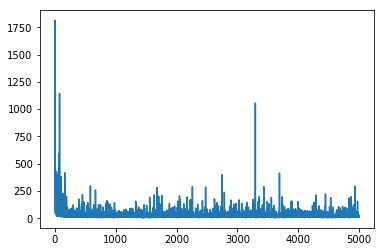

In [18]:
plt.figure()
plt.plot(losses)
plt.show()

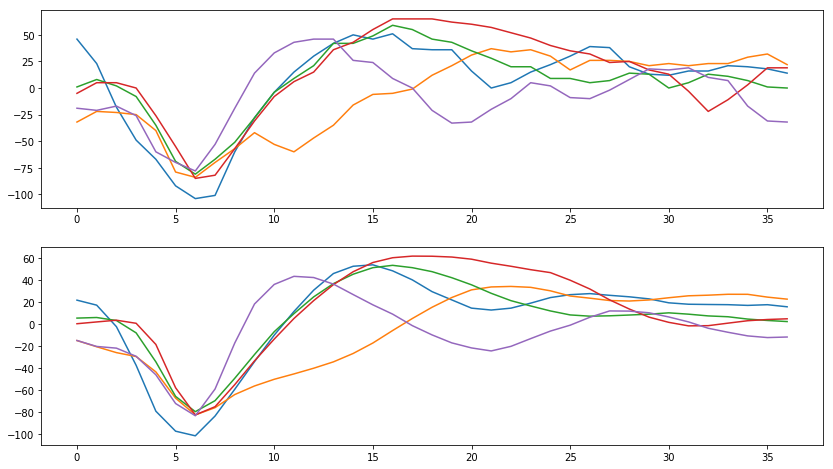

In [19]:
plt.figure(figsize=(14,8))

# n = [1, 30, 45, 50, 65]
n = [3490, 1098, 8707, 6709, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    plt.subplot(211)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(212)
    plt.plot(o)
plt.show()

In [20]:
torch.save(ae_1, 'models/neuropix/ae_01072018.pt')

## Using GANs for super-resolution

### Designing the GAN

In [21]:
class generator(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(generator, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [22]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

In [23]:
def train_gan(disc, gen, input_data, d_criterion, g_criterion, d_optimizer, g_optimizer, epoch_range,  
              batch_size_d, batch_size_g):
    for num_epoch in range(epoch_range):
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)

        for feats in d_selected:
            #---------Training the discriminator on real data------#
            real_data = input_data[feats, :]
            real_data = torch.from_numpy(real_data).float().cuda()
            #---------FORWARD------------#
            real_decision = disc.forward(real_data)
            real_decision = torch.tensor(real_decision).float().cuda()
            real_loss = d_criterion(real_decision, Variable(torch.ones(1)).cuda())
            #---------BACKWARD------------#
            real_loss.backward()
            
            #---------Training the discriminator on fake data------#
            enc, fake_data = gen.forward(real_data)
            fake_data = torch.tensor(fake_data).float().cuda()
            #---------FORWARD------------#
            fake_decision = disc.forward(fake_data)
            fake_decision = torch.tensor(fake_decision).float().cuda()
            fake_loss = d_criterion(fake_decision, Variable(torch.zeros(1)).cuda())
            #---------BACKWARD------------#
            fake_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        g_selected = random.sample(range(0, input_data.shape[0]), batch_size_g)
        
        for feats in g_selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = gen.forward(x)
            out = torch.tensor(out).float().cuda()
            g_loss = g_criterion(out, x)
            #---------BACKWARD------------#
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        print('epoch [{}/{}], disc_real_loss:{:.4f}, disc_fake_loss:{:.4f}, gen_loss:{:.4f}'.format(num_epoch + 1, 
                                                    epoch_range, real_loss.data[0], fake_loss.data[0], g_loss.data[0]))
    return out

In [24]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

In [25]:
epoch_range = 400
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.00001

# Defining the models
gen = generator(length, embedding_size).cuda()
disc = discriminator(length).cuda()

# Initialising the weights
gen.apply(init_gan_weights)
disc.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc.parameters(), lr=d_learning_rate, weight_decay=0.001)

out = train_gan(disc, gen, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/400], disc_real_loss:4.9509, disc_fake_loss:0.2827, gen_loss:499.0002
epoch [2/400], disc_real_loss:15.9988, disc_fake_loss:0.3041, gen_loss:1171.7206
epoch [3/400], disc_real_loss:1.8916, disc_fake_loss:0.8209, gen_loss:733.1874
epoch [4/400], disc_real_loss:13.1002, disc_fake_loss:1.7230, gen_loss:311.7327
epoch [5/400], disc_real_loss:7.3442, disc_fake_loss:1.7576, gen_loss:60.1776
epoch [6/400], disc_real_loss:0.3416, disc_fake_loss:1.7949, gen_loss:190.2719
epoch [7/400], disc_real_loss:3.1760, disc_fake_loss:0.0050, gen_loss:232.9698
epoch [8/400], disc_real_loss:2.6256, disc_fake_loss:1.2672, gen_loss:257.4593
epoch [9/400], disc_real_loss:3.4451, disc_fake_loss:1.3039, gen_loss:151.3537
epoch [10/400], disc_real_loss:0.2565, disc_fake_loss:1.2065, gen_loss:225.8303
epoch [11/400], disc_real_loss:4.7931, disc_fake_loss:1.7547, gen_loss:217.4691
epoch [12/400], disc_real_loss:2.3985, disc_fake_loss:1.7827, gen_loss:148.5760
epoch [13/400], disc_real_loss:7.2125, disc_fak

epoch [104/400], disc_real_loss:3.2919, disc_fake_loss:0.2246, gen_loss:44.5261
epoch [105/400], disc_real_loss:0.5420, disc_fake_loss:1.5104, gen_loss:24.4840
epoch [106/400], disc_real_loss:4.0096, disc_fake_loss:0.0652, gen_loss:68.0672
epoch [107/400], disc_real_loss:3.0916, disc_fake_loss:0.0015, gen_loss:19.0581
epoch [108/400], disc_real_loss:1.8730, disc_fake_loss:0.0019, gen_loss:33.4088
epoch [109/400], disc_real_loss:0.3777, disc_fake_loss:0.5929, gen_loss:186.8903
epoch [110/400], disc_real_loss:1.3672, disc_fake_loss:0.3681, gen_loss:122.3605
epoch [111/400], disc_real_loss:1.1840, disc_fake_loss:0.3014, gen_loss:92.5222
epoch [112/400], disc_real_loss:0.5655, disc_fake_loss:0.8780, gen_loss:203.0893
epoch [113/400], disc_real_loss:1.7367, disc_fake_loss:0.1286, gen_loss:37.1703
epoch [114/400], disc_real_loss:3.7003, disc_fake_loss:0.0160, gen_loss:53.3620
epoch [115/400], disc_real_loss:0.9461, disc_fake_loss:0.7639, gen_loss:40.3786
epoch [116/400], disc_real_loss:3.611

epoch [207/400], disc_real_loss:0.6162, disc_fake_loss:0.6926, gen_loss:31.6525
epoch [208/400], disc_real_loss:0.7459, disc_fake_loss:0.5490, gen_loss:137.7472
epoch [209/400], disc_real_loss:0.3637, disc_fake_loss:1.1374, gen_loss:29.4889
epoch [210/400], disc_real_loss:0.6120, disc_fake_loss:0.7726, gen_loss:42.8784
epoch [211/400], disc_real_loss:0.6467, disc_fake_loss:0.7108, gen_loss:25.0647
epoch [212/400], disc_real_loss:0.4877, disc_fake_loss:0.9537, gen_loss:21.7130
epoch [213/400], disc_real_loss:0.6329, disc_fake_loss:0.7414, gen_loss:16.3830
epoch [214/400], disc_real_loss:0.5630, disc_fake_loss:0.7309, gen_loss:29.8400
epoch [215/400], disc_real_loss:0.8229, disc_fake_loss:0.6361, gen_loss:36.9283
epoch [216/400], disc_real_loss:0.3642, disc_fake_loss:1.1843, gen_loss:60.3986
epoch [217/400], disc_real_loss:0.3807, disc_fake_loss:1.1286, gen_loss:19.4724
epoch [218/400], disc_real_loss:0.7125, disc_fake_loss:0.7051, gen_loss:17.1542
epoch [219/400], disc_real_loss:0.4219,

epoch [310/400], disc_real_loss:0.7105, disc_fake_loss:0.6770, gen_loss:17.5934
epoch [311/400], disc_real_loss:0.7113, disc_fake_loss:0.6761, gen_loss:32.9565
epoch [312/400], disc_real_loss:0.7089, disc_fake_loss:0.6770, gen_loss:10.5796
epoch [313/400], disc_real_loss:0.7103, disc_fake_loss:0.6761, gen_loss:14.5541
epoch [314/400], disc_real_loss:0.7042, disc_fake_loss:0.6814, gen_loss:37.2333
epoch [315/400], disc_real_loss:0.7078, disc_fake_loss:0.6787, gen_loss:47.8495
epoch [316/400], disc_real_loss:0.7011, disc_fake_loss:0.6846, gen_loss:46.2618
epoch [317/400], disc_real_loss:0.7077, disc_fake_loss:0.6783, gen_loss:36.9601
epoch [318/400], disc_real_loss:0.6809, disc_fake_loss:0.6882, gen_loss:14.3448
epoch [319/400], disc_real_loss:0.7082, disc_fake_loss:0.6786, gen_loss:17.5755
epoch [320/400], disc_real_loss:0.6981, disc_fake_loss:0.6825, gen_loss:33.1106
epoch [321/400], disc_real_loss:0.7015, disc_fake_loss:0.6861, gen_loss:45.5023
epoch [322/400], disc_real_loss:0.7055, 

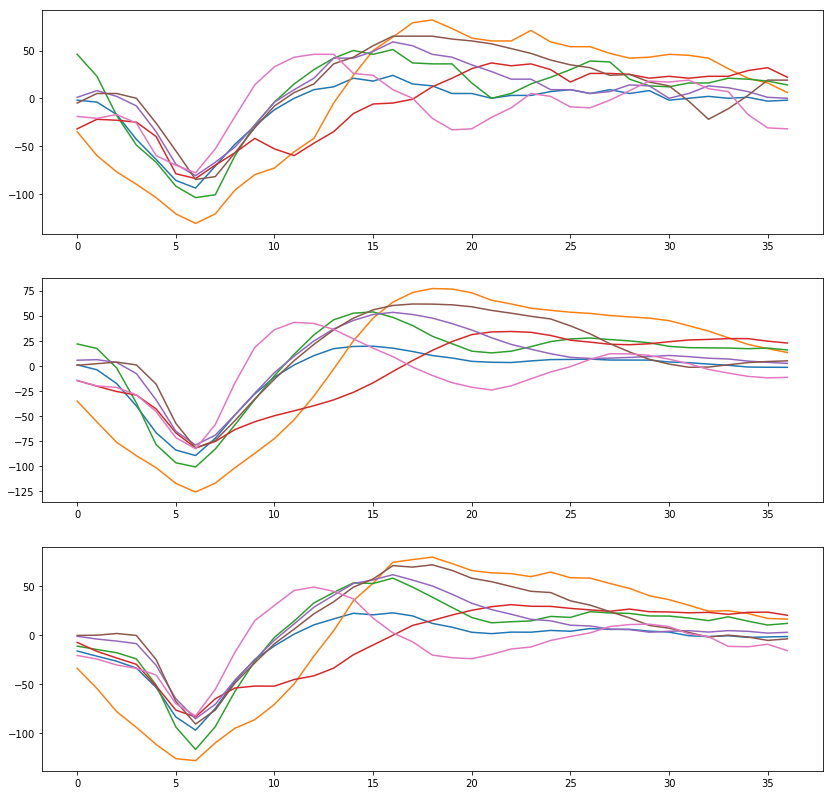

In [28]:
plt.figure(figsize=(14,14))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 8707, 6709, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    #print(np.sum(np.subtract(electrode_data_test[i, :], o)))
    enc, o_gan = gen.forward(data)
    o_gan = (o_gan.data).cpu().numpy()
    #print(np.sum(np.subtract(electrode_data_test[i, :], o_gan)))
    #print('-----------------')
    plt.subplot(311)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(312)
    plt.plot(o)
    plt.subplot(313)
    plt.plot(o_gan)
plt.show()

In [31]:
torch.save(gen, 'models/neuropix/gan_26062018.pt') #Saving the GAN model

## Designing LSTM-Autoencoders

In [32]:
class lstm_autoencoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(lstm_autoencoder, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.LSTM(input_size=input_size, hidden_size=75, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.LSTM(input_size=75, hidden_size=28, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.LSTM(input_size=embedding_size, hidden_size=16, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.LSTM(input_size=16, hidden_size=25, num_layers=2, bidirectional=True),
                                     activation_layer,
                                     nn.Linear(25, input_size))    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [33]:
random.seed(0)

def train_lstm(model, input_data, criterion, optimizer, epoch_range,  batch_size):
    losses = []
    for num_epoch in range(epoch_range):
        selected = random.sample(range(0, input_data.shape[0]), batch_size)
        for feats in selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = model.forward(x)
            out = torch.tensor(out).float().cuda()
            loss = criterion(out, x)
            #---------BACKWARD------------#
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data[0])
        print('epoch [{}/{}], loss:{:.5f}, avg:{:.5f}'.format(num_epoch + 1, epoch_range, 
                                                              loss.data[0], sum(losses[-10:])/len(losses[-10:])))
    return enc, out, losses

In [34]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear or type(layer) == nn.LSTM:
        nn.init.xavier_normal_(layer.weight)

In [35]:
epoch_range = 5000
batch_size = 150
learning_rate = 0.0001

lstm_ae = autoencoder(length, embedding_size).cuda()
lstm_ae.apply(init_weights)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    lstm_ae.parameters(), lr=learning_rate, weight_decay=0.001)

enc, out, losses = train_lstm(lstm_ae, electrode_data_train, criterion, optimizer, epoch_range, batch_size)

epoch [1/5000], loss:348.03415, avg:348.03415
epoch [2/5000], loss:586.48279, avg:467.25848
epoch [3/5000], loss:286.52036, avg:407.01245
epoch [4/5000], loss:636.45239, avg:464.37244
epoch [5/5000], loss:1082.67419, avg:588.03284
epoch [6/5000], loss:1533.07117, avg:745.53925
epoch [7/5000], loss:87.97452, avg:651.60144
epoch [8/5000], loss:243.93790, avg:600.64349
epoch [9/5000], loss:336.50586, avg:571.29486
epoch [10/5000], loss:479.16885, avg:562.08228
epoch [11/5000], loss:43.54926, avg:531.63379
epoch [12/5000], loss:65.49805, avg:479.53531
epoch [13/5000], loss:91.30708, avg:460.01398
epoch [14/5000], loss:86.87502, avg:405.05624
epoch [15/5000], loss:122.55180, avg:309.04395
epoch [16/5000], loss:30.34331, avg:158.77116
epoch [17/5000], loss:130.95242, avg:163.06895
epoch [18/5000], loss:196.14511, avg:158.28966
epoch [19/5000], loss:93.05533, avg:133.94463
epoch [20/5000], loss:237.52623, avg:109.78036
epoch [21/5000], loss:73.46977, avg:112.77242
epoch [22/5000], loss:42.040

epoch [179/5000], loss:44.60148, avg:42.85578
epoch [180/5000], loss:71.32293, avg:48.87249
epoch [181/5000], loss:37.47870, avg:50.55870
epoch [182/5000], loss:19.27297, avg:47.48019
epoch [183/5000], loss:20.66046, avg:43.17760
epoch [184/5000], loss:11.24745, avg:33.63555
epoch [185/5000], loss:33.81691, avg:32.22467
epoch [186/5000], loss:49.30271, avg:35.14486
epoch [187/5000], loss:49.23478, avg:35.91191
epoch [188/5000], loss:36.07605, avg:37.30145
epoch [189/5000], loss:134.17760, avg:46.25906
epoch [190/5000], loss:17.40849, avg:40.86761
epoch [191/5000], loss:17.55324, avg:38.87507
epoch [192/5000], loss:30.67782, avg:40.01555
epoch [193/5000], loss:57.41275, avg:43.69078
epoch [194/5000], loss:25.82427, avg:45.14846
epoch [195/5000], loss:21.64815, avg:43.93159
epoch [196/5000], loss:36.93353, avg:42.69467
epoch [197/5000], loss:25.53021, avg:40.32421
epoch [198/5000], loss:12.40099, avg:37.95671
epoch [199/5000], loss:49.58063, avg:29.49701
epoch [200/5000], loss:18.58633, 

epoch [358/5000], loss:19.39226, avg:29.95006
epoch [359/5000], loss:86.72176, avg:35.74728
epoch [360/5000], loss:12.52329, avg:32.37132
epoch [361/5000], loss:23.98204, avg:30.32021
epoch [362/5000], loss:16.35986, avg:29.54086
epoch [363/5000], loss:20.11043, avg:27.19595
epoch [364/5000], loss:30.38143, avg:28.52276
epoch [365/5000], loss:18.66054, avg:28.82245
epoch [366/5000], loss:22.34135, avg:28.80427
epoch [367/5000], loss:86.29753, avg:33.67705
epoch [368/5000], loss:73.16248, avg:39.05407
epoch [369/5000], loss:14.03753, avg:31.78565
epoch [370/5000], loss:19.01847, avg:32.43517
epoch [371/5000], loss:14.96260, avg:31.53322
epoch [372/5000], loss:30.04858, avg:32.90210
epoch [373/5000], loss:49.73135, avg:35.86419
epoch [374/5000], loss:33.92421, avg:36.21847
epoch [375/5000], loss:23.98293, avg:36.75070
epoch [376/5000], loss:43.51871, avg:38.86844
epoch [377/5000], loss:19.80340, avg:32.21903
epoch [378/5000], loss:34.47783, avg:28.35056
epoch [379/5000], loss:10.42243, a

epoch [537/5000], loss:22.12004, avg:22.97324
epoch [538/5000], loss:17.85882, avg:23.05437
epoch [539/5000], loss:8.12810, avg:19.07454
epoch [540/5000], loss:29.26397, avg:19.87918
epoch [541/5000], loss:24.33728, avg:20.78318
epoch [542/5000], loss:132.53539, avg:30.32605
epoch [543/5000], loss:50.11174, avg:33.82154
epoch [544/5000], loss:15.25942, avg:32.72932
epoch [545/5000], loss:30.37913, avg:35.21798
epoch [546/5000], loss:16.00112, avg:34.59950
epoch [547/5000], loss:16.40093, avg:34.02759
epoch [548/5000], loss:20.51224, avg:34.29293
epoch [549/5000], loss:16.93451, avg:35.17357
epoch [550/5000], loss:38.04896, avg:36.05207
epoch [551/5000], loss:27.42137, avg:36.36048
epoch [552/5000], loss:17.14344, avg:24.82129
epoch [553/5000], loss:89.91428, avg:28.80154
epoch [554/5000], loss:38.56490, avg:31.13209
epoch [555/5000], loss:12.95886, avg:29.39006
epoch [556/5000], loss:59.17632, avg:33.70758
epoch [557/5000], loss:115.07333, avg:43.57483
epoch [558/5000], loss:10.83766, 

epoch [716/5000], loss:34.52456, avg:37.86889
epoch [717/5000], loss:15.82671, avg:37.93921
epoch [718/5000], loss:11.83795, avg:37.05050
epoch [719/5000], loss:8.51318, avg:35.22104
epoch [720/5000], loss:108.88183, avg:44.09941
epoch [721/5000], loss:28.69749, avg:43.22453
epoch [722/5000], loss:7.53053, avg:35.71875
epoch [723/5000], loss:9.11025, avg:29.56526
epoch [724/5000], loss:8.68476, avg:26.58785
epoch [725/5000], loss:31.34653, avg:26.49538
epoch [726/5000], loss:15.51206, avg:24.59413
epoch [727/5000], loss:23.61693, avg:25.37315
epoch [728/5000], loss:17.80429, avg:25.96978
epoch [729/5000], loss:6.83850, avg:25.80231
epoch [730/5000], loss:76.57786, avg:22.57192
epoch [731/5000], loss:36.28921, avg:23.33109
epoch [732/5000], loss:9.99598, avg:23.57764
epoch [733/5000], loss:10.36749, avg:23.70336
epoch [734/5000], loss:20.17927, avg:24.85281
epoch [735/5000], loss:10.85480, avg:22.80364
epoch [736/5000], loss:17.80639, avg:23.03307
epoch [737/5000], loss:24.01680, avg:23

epoch [895/5000], loss:13.83280, avg:19.25489
epoch [896/5000], loss:37.99284, avg:20.91723
epoch [897/5000], loss:12.31137, avg:20.03168
epoch [898/5000], loss:23.96600, avg:21.17292
epoch [899/5000], loss:36.63269, avg:23.07440
epoch [900/5000], loss:33.15001, avg:23.93846
epoch [901/5000], loss:37.51011, avg:25.84438
epoch [902/5000], loss:31.95845, avg:25.11744
epoch [903/5000], loss:116.00014, avg:35.86380
epoch [904/5000], loss:14.65844, avg:35.80128
epoch [905/5000], loss:37.48832, avg:38.16684
epoch [906/5000], loss:51.24060, avg:39.49162
epoch [907/5000], loss:20.05536, avg:40.26601
epoch [908/5000], loss:28.00119, avg:40.66953
epoch [909/5000], loss:44.13218, avg:41.41948
epoch [910/5000], loss:153.69223, avg:53.47371
epoch [911/5000], loss:22.84444, avg:52.00714
epoch [912/5000], loss:32.20210, avg:52.03150
epoch [913/5000], loss:17.15925, avg:42.14741
epoch [914/5000], loss:13.37542, avg:42.01910
epoch [915/5000], loss:55.92678, avg:43.86296
epoch [916/5000], loss:24.10445,

epoch [1072/5000], loss:8.83036, avg:14.98911
epoch [1073/5000], loss:14.37525, avg:14.82867
epoch [1074/5000], loss:50.53919, avg:17.43419
epoch [1075/5000], loss:30.64343, avg:19.64777
epoch [1076/5000], loss:9.83377, avg:19.65454
epoch [1077/5000], loss:25.67891, avg:20.49478
epoch [1078/5000], loss:34.81234, avg:23.09763
epoch [1079/5000], loss:51.67396, avg:25.75156
epoch [1080/5000], loss:20.49632, avg:26.86849
epoch [1081/5000], loss:23.05293, avg:26.99364
epoch [1082/5000], loss:42.82130, avg:30.39274
epoch [1083/5000], loss:47.81825, avg:33.73704
epoch [1084/5000], loss:21.88159, avg:30.87128
epoch [1085/5000], loss:30.36846, avg:30.84378
epoch [1086/5000], loss:12.66947, avg:31.12735
epoch [1087/5000], loss:10.95889, avg:29.65535
epoch [1088/5000], loss:11.51593, avg:27.32571
epoch [1089/5000], loss:24.04177, avg:24.56249
epoch [1090/5000], loss:9.42150, avg:23.45501
epoch [1091/5000], loss:23.47436, avg:23.49715
epoch [1092/5000], loss:19.05760, avg:21.12078
epoch [1093/5000

epoch [1247/5000], loss:13.07948, avg:26.83248
epoch [1248/5000], loss:43.79711, avg:28.40947
epoch [1249/5000], loss:23.84143, avg:28.89804
epoch [1250/5000], loss:9.45860, avg:25.69515
epoch [1251/5000], loss:15.34789, avg:25.51076
epoch [1252/5000], loss:19.70079, avg:23.34863
epoch [1253/5000], loss:20.06782, avg:20.77958
epoch [1254/5000], loss:18.43975, avg:19.06538
epoch [1255/5000], loss:91.60514, avg:26.82065
epoch [1256/5000], loss:10.10246, avg:26.54405
epoch [1257/5000], loss:89.23976, avg:34.16008
epoch [1258/5000], loss:32.20435, avg:33.00080
epoch [1259/5000], loss:65.50945, avg:37.16760
epoch [1260/5000], loss:25.25286, avg:38.74703
epoch [1261/5000], loss:32.44593, avg:40.45683
epoch [1262/5000], loss:25.35171, avg:41.02192
epoch [1263/5000], loss:15.93873, avg:40.60902
epoch [1264/5000], loss:13.16483, avg:40.08152
epoch [1265/5000], loss:11.00488, avg:32.02150
epoch [1266/5000], loss:11.46991, avg:32.15824
epoch [1267/5000], loss:17.68726, avg:25.00299
epoch [1268/50

epoch [1422/5000], loss:23.04938, avg:29.49236
epoch [1423/5000], loss:8.20773, avg:29.06065
epoch [1424/5000], loss:67.63749, avg:32.63321
epoch [1425/5000], loss:8.16351, avg:32.06592
epoch [1426/5000], loss:24.32325, avg:30.01150
epoch [1427/5000], loss:25.19854, avg:29.74858
epoch [1428/5000], loss:11.70509, avg:28.18575
epoch [1429/5000], loss:19.59206, avg:28.70199
epoch [1430/5000], loss:23.20756, avg:22.03838
epoch [1431/5000], loss:14.22163, avg:22.53063
epoch [1432/5000], loss:5.75989, avg:20.80167
epoch [1433/5000], loss:18.19296, avg:21.80020
epoch [1434/5000], loss:29.63634, avg:18.00008
epoch [1435/5000], loss:13.05680, avg:18.48941
epoch [1436/5000], loss:7.97381, avg:16.85447
epoch [1437/5000], loss:11.34218, avg:15.46883
epoch [1438/5000], loss:50.56451, avg:19.35477
epoch [1439/5000], loss:14.75758, avg:18.87133
epoch [1440/5000], loss:72.84607, avg:23.83518
epoch [1441/5000], loss:9.01045, avg:23.31406
epoch [1442/5000], loss:15.66494, avg:24.30457
epoch [1443/5000],

epoch [1597/5000], loss:19.17396, avg:23.01870
epoch [1598/5000], loss:38.58986, avg:22.50921
epoch [1599/5000], loss:17.69465, avg:23.10281
epoch [1600/5000], loss:9.72597, avg:22.16797
epoch [1601/5000], loss:32.93812, avg:24.29543
epoch [1602/5000], loss:16.47543, avg:22.47561
epoch [1603/5000], loss:12.72971, avg:21.27864
epoch [1604/5000], loss:8.85227, avg:19.70356
epoch [1605/5000], loss:22.59150, avg:19.62084
epoch [1606/5000], loss:14.37198, avg:19.31435
epoch [1607/5000], loss:11.84776, avg:18.58173
epoch [1608/5000], loss:62.09455, avg:20.93220
epoch [1609/5000], loss:97.81248, avg:28.94398
epoch [1610/5000], loss:20.40572, avg:30.01195
epoch [1611/5000], loss:40.98708, avg:30.81685
epoch [1612/5000], loss:24.76459, avg:31.64577
epoch [1613/5000], loss:16.50401, avg:32.02319
epoch [1614/5000], loss:15.14516, avg:32.65248
epoch [1615/5000], loss:12.71190, avg:31.66452
epoch [1616/5000], loss:10.84195, avg:31.31152
epoch [1617/5000], loss:16.76008, avg:31.80275
epoch [1618/500

epoch [1772/5000], loss:15.85510, avg:21.72409
epoch [1773/5000], loss:19.86710, avg:22.04077
epoch [1774/5000], loss:16.80828, avg:22.31099
epoch [1775/5000], loss:9.62265, avg:20.70650
epoch [1776/5000], loss:58.51941, avg:24.88290
epoch [1777/5000], loss:19.56327, avg:25.38328
epoch [1778/5000], loss:8.84352, avg:24.79963
epoch [1779/5000], loss:32.45457, avg:22.09710
epoch [1780/5000], loss:11.48501, avg:21.13944
epoch [1781/5000], loss:45.10249, avg:23.81214
epoch [1782/5000], loss:7.18676, avg:22.94531
epoch [1783/5000], loss:28.74822, avg:23.83342
epoch [1784/5000], loss:41.14814, avg:26.26740
epoch [1785/5000], loss:22.71602, avg:27.57674
epoch [1786/5000], loss:17.26526, avg:23.45133
epoch [1787/5000], loss:36.10289, avg:25.10529
epoch [1788/5000], loss:12.60911, avg:25.48185
epoch [1789/5000], loss:14.71441, avg:23.70783
epoch [1790/5000], loss:22.27108, avg:24.78644
epoch [1791/5000], loss:7.45687, avg:21.02188
epoch [1792/5000], loss:35.71281, avg:23.87448
epoch [1793/5000]

epoch [1947/5000], loss:28.07465, avg:19.97711
epoch [1948/5000], loss:90.29290, avg:27.30137
epoch [1949/5000], loss:9.02373, avg:27.12165
epoch [1950/5000], loss:8.16942, avg:26.70612
epoch [1951/5000], loss:30.67690, avg:28.19560
epoch [1952/5000], loss:36.46848, avg:28.70782
epoch [1953/5000], loss:16.40836, avg:28.37197
epoch [1954/5000], loss:19.54989, avg:29.33603
epoch [1955/5000], loss:19.47420, avg:26.75686
epoch [1956/5000], loss:9.00893, avg:26.71474
epoch [1957/5000], loss:19.66516, avg:25.87379
epoch [1958/5000], loss:7.85973, avg:17.63048
epoch [1959/5000], loss:8.69659, avg:17.59777
epoch [1960/5000], loss:19.76329, avg:18.75715
epoch [1961/5000], loss:42.36087, avg:19.92555
epoch [1962/5000], loss:8.13673, avg:17.09237
epoch [1963/5000], loss:19.27844, avg:17.37938
epoch [1964/5000], loss:39.36920, avg:19.36131
epoch [1965/5000], loss:16.54225, avg:19.06812
epoch [1966/5000], loss:16.98749, avg:19.86597
epoch [1967/5000], loss:13.09000, avg:19.20846
epoch [1968/5000], 

epoch [2122/5000], loss:33.57659, avg:19.01498
epoch [2123/5000], loss:134.29112, avg:31.27689
epoch [2124/5000], loss:48.01439, avg:32.69105
epoch [2125/5000], loss:25.26716, avg:33.74970
epoch [2126/5000], loss:14.18661, avg:33.75653
epoch [2127/5000], loss:35.46218, avg:35.58421
epoch [2128/5000], loss:15.32548, avg:35.28684
epoch [2129/5000], loss:14.27382, avg:35.44045
epoch [2130/5000], loss:50.80642, avg:38.20606
epoch [2131/5000], loss:17.93712, avg:38.91409
epoch [2132/5000], loss:5.72223, avg:36.12865
epoch [2133/5000], loss:102.36720, avg:32.93626
epoch [2134/5000], loss:18.45797, avg:29.98062
epoch [2135/5000], loss:33.37577, avg:30.79148
epoch [2136/5000], loss:10.40671, avg:30.41349
epoch [2137/5000], loss:21.79481, avg:29.04675
epoch [2138/5000], loss:17.33241, avg:29.24744
epoch [2139/5000], loss:12.55494, avg:29.07556
epoch [2140/5000], loss:14.91372, avg:25.48629
epoch [2141/5000], loss:17.38535, avg:25.43111
epoch [2142/5000], loss:26.73467, avg:27.53235
epoch [2143/

epoch [2297/5000], loss:35.45306, avg:25.24357
epoch [2298/5000], loss:18.53118, avg:23.99741
epoch [2299/5000], loss:23.03601, avg:21.64013
epoch [2300/5000], loss:19.61129, avg:20.41826
epoch [2301/5000], loss:13.34333, avg:18.98155
epoch [2302/5000], loss:10.41523, avg:18.33191
epoch [2303/5000], loss:22.53868, avg:19.23312
epoch [2304/5000], loss:19.24551, avg:18.50214
epoch [2305/5000], loss:13.27330, avg:18.43777
epoch [2306/5000], loss:12.67281, avg:18.81204
epoch [2307/5000], loss:20.93360, avg:17.36009
epoch [2308/5000], loss:12.08061, avg:16.71504
epoch [2309/5000], loss:7.52235, avg:15.16367
epoch [2310/5000], loss:13.53829, avg:14.55637
epoch [2311/5000], loss:12.60120, avg:14.48216
epoch [2312/5000], loss:16.41062, avg:15.08170
epoch [2313/5000], loss:20.92671, avg:14.92050
epoch [2314/5000], loss:93.56545, avg:22.35250
epoch [2315/5000], loss:8.14386, avg:21.83955
epoch [2316/5000], loss:10.26574, avg:21.59884
epoch [2317/5000], loss:20.01823, avg:21.50731
epoch [2318/500

epoch [2472/5000], loss:18.73835, avg:37.02889
epoch [2473/5000], loss:9.30119, avg:29.11921
epoch [2474/5000], loss:55.34527, avg:33.71574
epoch [2475/5000], loss:16.48394, avg:33.65402
epoch [2476/5000], loss:26.62076, avg:33.44301
epoch [2477/5000], loss:37.01212, avg:34.44474
epoch [2478/5000], loss:288.91180, avg:53.11988
epoch [2479/5000], loss:11.07390, avg:52.16999
epoch [2480/5000], loss:12.87576, avg:50.81301
epoch [2481/5000], loss:41.23942, avg:51.76025
epoch [2482/5000], loss:10.93855, avg:50.98027
epoch [2483/5000], loss:19.70290, avg:52.02044
epoch [2484/5000], loss:36.23056, avg:50.10897
epoch [2485/5000], loss:14.97913, avg:49.95849
epoch [2486/5000], loss:9.57505, avg:48.25392
epoch [2487/5000], loss:15.56582, avg:46.10929
epoch [2488/5000], loss:26.42730, avg:19.86084
epoch [2489/5000], loss:22.07227, avg:20.96068
epoch [2490/5000], loss:29.18408, avg:22.59151
epoch [2491/5000], loss:31.60109, avg:21.62768
epoch [2492/5000], loss:46.83278, avg:25.21710
epoch [2493/50

epoch [2647/5000], loss:39.73331, avg:27.65272
epoch [2648/5000], loss:20.21362, avg:28.60515
epoch [2649/5000], loss:19.81868, avg:28.96570
epoch [2650/5000], loss:14.26151, avg:19.54574
epoch [2651/5000], loss:15.46709, avg:19.69215
epoch [2652/5000], loss:6.33239, avg:18.53134
epoch [2653/5000], loss:39.35387, avg:20.45163
epoch [2654/5000], loss:18.83157, avg:20.87081
epoch [2655/5000], loss:7.04351, avg:19.23732
epoch [2656/5000], loss:11.51125, avg:19.25668
epoch [2657/5000], loss:15.39023, avg:16.82237
epoch [2658/5000], loss:14.74588, avg:16.27560
epoch [2659/5000], loss:16.63831, avg:15.95756
epoch [2660/5000], loss:11.76113, avg:15.70752
epoch [2661/5000], loss:125.67010, avg:26.72783
epoch [2662/5000], loss:17.40457, avg:27.83504
epoch [2663/5000], loss:29.18796, avg:26.81845
epoch [2664/5000], loss:21.10908, avg:27.04620
epoch [2665/5000], loss:147.99397, avg:41.14125
epoch [2666/5000], loss:15.74973, avg:41.56510
epoch [2667/5000], loss:36.03867, avg:43.62994
epoch [2668/5

epoch [2822/5000], loss:33.63858, avg:28.16597
epoch [2823/5000], loss:23.13972, avg:26.51358
epoch [2824/5000], loss:18.02472, avg:24.43384
epoch [2825/5000], loss:23.80564, avg:25.86047
epoch [2826/5000], loss:18.82930, avg:26.01726
epoch [2827/5000], loss:19.52536, avg:22.87860
epoch [2828/5000], loss:15.14210, avg:21.64944
epoch [2829/5000], loss:50.02375, avg:24.09011
epoch [2830/5000], loss:16.39525, avg:23.38753
epoch [2831/5000], loss:18.05602, avg:23.65805
epoch [2832/5000], loss:6.94924, avg:20.98911
epoch [2833/5000], loss:14.84715, avg:20.15985
epoch [2834/5000], loss:38.40629, avg:22.19801
epoch [2835/5000], loss:60.87222, avg:25.90467
epoch [2836/5000], loss:31.19168, avg:27.14091
epoch [2837/5000], loss:18.97856, avg:27.08623
epoch [2838/5000], loss:15.92578, avg:27.16459
epoch [2839/5000], loss:29.67166, avg:25.12938
epoch [2840/5000], loss:31.46906, avg:26.63677
epoch [2841/5000], loss:15.27398, avg:26.35856
epoch [2842/5000], loss:60.80553, avg:31.74419
epoch [2843/50

epoch [2997/5000], loss:18.75592, avg:23.66433
epoch [2998/5000], loss:40.85667, avg:26.38959
epoch [2999/5000], loss:32.57059, avg:25.42164
epoch [3000/5000], loss:12.57783, avg:25.22004
epoch [3001/5000], loss:34.00447, avg:25.34941
epoch [3002/5000], loss:38.38331, avg:24.97548
epoch [3003/5000], loss:66.52944, avg:30.08798
epoch [3004/5000], loss:9.77240, avg:29.08619
epoch [3005/5000], loss:52.48764, avg:32.30258
epoch [3006/5000], loss:16.04764, avg:32.19859
epoch [3007/5000], loss:23.29061, avg:32.65206
epoch [3008/5000], loss:10.29506, avg:29.59590
epoch [3009/5000], loss:16.31182, avg:27.97002
epoch [3010/5000], loss:38.54372, avg:30.56661
epoch [3011/5000], loss:15.59662, avg:28.72582
epoch [3012/5000], loss:14.31914, avg:26.31941
epoch [3013/5000], loss:19.25677, avg:21.59214
epoch [3014/5000], loss:37.89732, avg:24.40464
epoch [3015/5000], loss:22.11956, avg:21.36783
epoch [3016/5000], loss:15.06607, avg:21.26967
epoch [3017/5000], loss:48.21504, avg:23.76211
epoch [3018/50

epoch [3172/5000], loss:14.63095, avg:21.84170
epoch [3173/5000], loss:28.30428, avg:21.77920
epoch [3174/5000], loss:15.56863, avg:21.80810
epoch [3175/5000], loss:29.22728, avg:23.13116
epoch [3176/5000], loss:30.38831, avg:23.04619
epoch [3177/5000], loss:19.90953, avg:21.18159
epoch [3178/5000], loss:19.04134, avg:21.70166
epoch [3179/5000], loss:8.32785, avg:21.42600
epoch [3180/5000], loss:24.66054, avg:20.31114
epoch [3181/5000], loss:31.80432, avg:22.18630
epoch [3182/5000], loss:107.68909, avg:31.49212
epoch [3183/5000], loss:14.53291, avg:30.11498
epoch [3184/5000], loss:8.71252, avg:29.42937
epoch [3185/5000], loss:8.64794, avg:27.37144
epoch [3186/5000], loss:14.95674, avg:25.82828
epoch [3187/5000], loss:17.64128, avg:25.60145
epoch [3188/5000], loss:28.55728, avg:26.55305
epoch [3189/5000], loss:20.30436, avg:27.75070
epoch [3190/5000], loss:10.01116, avg:26.28576
epoch [3191/5000], loss:8.36523, avg:23.94185
epoch [3192/5000], loss:39.34009, avg:17.10695
epoch [3193/5000

epoch [3347/5000], loss:29.41553, avg:40.46774
epoch [3348/5000], loss:40.38457, avg:36.77666
epoch [3349/5000], loss:11.57542, avg:35.16892
epoch [3350/5000], loss:36.33461, avg:23.78870
epoch [3351/5000], loss:34.79217, avg:26.18636
epoch [3352/5000], loss:40.92807, avg:25.15894
epoch [3353/5000], loss:15.95805, avg:25.69360
epoch [3354/5000], loss:43.10740, avg:27.89970
epoch [3355/5000], loss:29.95017, avg:29.75499
epoch [3356/5000], loss:14.51879, avg:29.69648
epoch [3357/5000], loss:36.70824, avg:30.42575
epoch [3358/5000], loss:37.15507, avg:30.10280
epoch [3359/5000], loss:10.13950, avg:29.95920
epoch [3360/5000], loss:190.06174, avg:45.33192
epoch [3361/5000], loss:18.21949, avg:43.67465
epoch [3362/5000], loss:25.01123, avg:42.08297
epoch [3363/5000], loss:9.10092, avg:41.39725
epoch [3364/5000], loss:12.83794, avg:38.37031
epoch [3365/5000], loss:20.65848, avg:37.44114
epoch [3366/5000], loss:8.57820, avg:36.84708
epoch [3367/5000], loss:15.38828, avg:34.71508
epoch [3368/50

epoch [3522/5000], loss:14.19063, avg:36.68948
epoch [3523/5000], loss:7.64485, avg:36.03207
epoch [3524/5000], loss:77.97303, avg:40.18202
epoch [3525/5000], loss:9.55757, avg:30.00437
epoch [3526/5000], loss:13.83013, avg:28.01818
epoch [3527/5000], loss:36.69839, avg:30.36625
epoch [3528/5000], loss:11.30808, avg:30.13840
epoch [3529/5000], loss:36.11069, avg:27.44563
epoch [3530/5000], loss:8.70242, avg:27.05574
epoch [3531/5000], loss:51.42852, avg:26.74443
epoch [3532/5000], loss:41.22892, avg:29.44826
epoch [3533/5000], loss:43.92953, avg:33.07673
epoch [3534/5000], loss:11.05980, avg:26.38541
epoch [3535/5000], loss:25.91608, avg:28.02126
epoch [3536/5000], loss:18.52189, avg:28.49043
epoch [3537/5000], loss:30.00114, avg:27.82071
epoch [3538/5000], loss:13.29371, avg:28.01927
epoch [3539/5000], loss:37.14814, avg:28.12302
epoch [3540/5000], loss:40.14943, avg:31.26772
epoch [3541/5000], loss:13.35592, avg:27.46046
epoch [3542/5000], loss:19.01823, avg:25.23939
epoch [3543/5000

epoch [3697/5000], loss:11.69349, avg:54.03506
epoch [3698/5000], loss:47.45223, avg:57.48822
epoch [3699/5000], loss:10.26220, avg:57.40376
epoch [3700/5000], loss:42.28950, avg:60.59398
epoch [3701/5000], loss:27.63775, avg:24.11667
epoch [3702/5000], loss:8.79050, avg:23.90409
epoch [3703/5000], loss:20.30538, avg:24.87908
epoch [3704/5000], loss:32.21630, avg:25.16785
epoch [3705/5000], loss:10.19431, avg:25.16649
epoch [3706/5000], loss:36.76911, avg:24.76108
epoch [3707/5000], loss:38.17028, avg:27.40876
epoch [3708/5000], loss:16.51217, avg:24.31475
epoch [3709/5000], loss:9.62567, avg:24.25110
epoch [3710/5000], loss:34.39352, avg:23.46150
epoch [3711/5000], loss:10.25245, avg:21.72297
epoch [3712/5000], loss:16.37596, avg:22.48152
epoch [3713/5000], loss:13.85410, avg:21.83639
epoch [3714/5000], loss:15.02928, avg:20.11769
epoch [3715/5000], loss:14.09031, avg:20.50729
epoch [3716/5000], loss:17.06967, avg:18.53734
epoch [3717/5000], loss:19.48958, avg:16.66927
epoch [3718/500

epoch [3872/5000], loss:69.08835, avg:31.34768
epoch [3873/5000], loss:22.35120, avg:32.55766
epoch [3874/5000], loss:101.45925, avg:41.08741
epoch [3875/5000], loss:30.53510, avg:40.68991
epoch [3876/5000], loss:16.11372, avg:41.28826
epoch [3877/5000], loss:60.93095, avg:46.39120
epoch [3878/5000], loss:37.74075, avg:48.34343
epoch [3879/5000], loss:30.22345, avg:48.05329
epoch [3880/5000], loss:70.90041, avg:48.13307
epoch [3881/5000], loss:149.27716, avg:58.86204
epoch [3882/5000], loss:23.68472, avg:54.32167
epoch [3883/5000], loss:47.93583, avg:56.88013
epoch [3884/5000], loss:29.43060, avg:49.67727
epoch [3885/5000], loss:15.03680, avg:48.12744
epoch [3886/5000], loss:17.30021, avg:48.24609
epoch [3887/5000], loss:30.92038, avg:45.24503
epoch [3888/5000], loss:11.96742, avg:42.66769
epoch [3889/5000], loss:27.19775, avg:42.36512
epoch [3890/5000], loss:17.91088, avg:37.06617
epoch [3891/5000], loss:6.06270, avg:22.74473
epoch [3892/5000], loss:22.93778, avg:22.67003
epoch [3893/

epoch [4047/5000], loss:13.52316, avg:27.21567
epoch [4048/5000], loss:10.06962, avg:19.86165
epoch [4049/5000], loss:12.61993, avg:19.33141
epoch [4050/5000], loss:17.54550, avg:19.23350
epoch [4051/5000], loss:6.08111, avg:18.33333
epoch [4052/5000], loss:49.43090, avg:22.35201
epoch [4053/5000], loss:20.00869, avg:21.89149
epoch [4054/5000], loss:14.06895, avg:20.47355
epoch [4055/5000], loss:10.18972, avg:16.66002
epoch [4056/5000], loss:10.46224, avg:16.39998
epoch [4057/5000], loss:13.58213, avg:16.40588
epoch [4058/5000], loss:20.03074, avg:17.40199
epoch [4059/5000], loss:28.34985, avg:18.97498
epoch [4060/5000], loss:7.01804, avg:17.92224
epoch [4061/5000], loss:22.25262, avg:19.53939
epoch [4062/5000], loss:15.31028, avg:16.12733
epoch [4063/5000], loss:66.67849, avg:20.79431
epoch [4064/5000], loss:22.79041, avg:21.66645
epoch [4065/5000], loss:24.70606, avg:23.11809
epoch [4066/5000], loss:16.29777, avg:23.70164
epoch [4067/5000], loss:14.43748, avg:23.78717
epoch [4068/500

epoch [4222/5000], loss:14.33608, avg:18.53626
epoch [4223/5000], loss:25.14995, avg:19.33198
epoch [4224/5000], loss:40.17677, avg:21.87513
epoch [4225/5000], loss:10.47501, avg:20.52443
epoch [4226/5000], loss:27.33686, avg:22.19298
epoch [4227/5000], loss:12.38586, avg:21.69702
epoch [4228/5000], loss:18.85959, avg:21.25623
epoch [4229/5000], loss:11.51274, avg:21.12900
epoch [4230/5000], loss:13.63262, avg:20.67332
epoch [4231/5000], loss:11.76657, avg:18.56321
epoch [4232/5000], loss:13.94630, avg:18.52423
epoch [4233/5000], loss:20.26471, avg:18.03570
epoch [4234/5000], loss:126.74519, avg:26.69255
epoch [4235/5000], loss:23.67639, avg:28.01268
epoch [4236/5000], loss:25.96043, avg:27.87504
epoch [4237/5000], loss:10.48144, avg:27.68460
epoch [4238/5000], loss:55.13402, avg:31.31205
epoch [4239/5000], loss:13.62418, avg:31.52319
epoch [4240/5000], loss:23.24279, avg:32.48420
epoch [4241/5000], loss:13.09053, avg:32.61660
epoch [4242/5000], loss:14.77335, avg:32.69931
epoch [4243/

epoch [4397/5000], loss:20.41830, avg:18.88236
epoch [4398/5000], loss:17.40287, avg:19.78754
epoch [4399/5000], loss:24.41375, avg:17.90992
epoch [4400/5000], loss:14.27174, avg:17.31243
epoch [4401/5000], loss:19.92801, avg:17.56609
epoch [4402/5000], loss:62.33571, avg:23.31927
epoch [4403/5000], loss:6.21051, avg:21.34893
epoch [4404/5000], loss:53.43200, avg:24.66523
epoch [4405/5000], loss:13.02013, avg:25.18399
epoch [4406/5000], loss:13.86303, avg:24.52961
epoch [4407/5000], loss:18.47163, avg:24.33494
epoch [4408/5000], loss:17.71983, avg:24.36664
epoch [4409/5000], loss:20.70662, avg:23.99592
epoch [4410/5000], loss:54.17005, avg:27.98575
epoch [4411/5000], loss:19.76854, avg:27.96981
epoch [4412/5000], loss:38.80742, avg:25.61698
epoch [4413/5000], loss:13.09600, avg:26.30553
epoch [4414/5000], loss:25.84901, avg:23.54723
epoch [4415/5000], loss:9.10052, avg:23.15527
epoch [4416/5000], loss:19.53578, avg:23.72254
epoch [4417/5000], loss:10.70709, avg:22.94609
epoch [4418/500

epoch [4572/5000], loss:26.70823, avg:32.08129
epoch [4573/5000], loss:38.85441, avg:34.57173
epoch [4574/5000], loss:17.95396, avg:34.40543
epoch [4575/5000], loss:49.52055, avg:37.82906
epoch [4576/5000], loss:30.18081, avg:30.31647
epoch [4577/5000], loss:67.07664, avg:36.05305
epoch [4578/5000], loss:18.69394, avg:36.33165
epoch [4579/5000], loss:41.40665, avg:38.27183
epoch [4580/5000], loss:33.27528, avg:33.38526
epoch [4581/5000], loss:16.66434, avg:34.03348
epoch [4582/5000], loss:25.49823, avg:33.91248
epoch [4583/5000], loss:24.15773, avg:32.44282
epoch [4584/5000], loss:16.11543, avg:32.25896
epoch [4585/5000], loss:6.65446, avg:27.97235
epoch [4586/5000], loss:28.01551, avg:27.75582
epoch [4587/5000], loss:32.89866, avg:24.33802
epoch [4588/5000], loss:20.70126, avg:24.53875
epoch [4589/5000], loss:19.29929, avg:22.32802
epoch [4590/5000], loss:29.02884, avg:21.90337
epoch [4591/5000], loss:25.16989, avg:22.75393
epoch [4592/5000], loss:16.22759, avg:21.82686
epoch [4593/50

epoch [4747/5000], loss:13.12149, avg:19.95877
epoch [4748/5000], loss:10.58063, avg:18.87850
epoch [4749/5000], loss:74.17384, avg:24.04996
epoch [4750/5000], loss:12.79892, avg:23.97928
epoch [4751/5000], loss:32.34080, avg:26.02015
epoch [4752/5000], loss:13.04660, avg:25.90474
epoch [4753/5000], loss:5.86740, avg:24.50782
epoch [4754/5000], loss:49.87889, avg:25.44158
epoch [4755/5000], loss:18.95811, avg:24.62102
epoch [4756/5000], loss:46.09282, avg:27.68595
epoch [4757/5000], loss:36.36586, avg:30.01039
epoch [4758/5000], loss:22.20142, avg:31.17246
epoch [4759/5000], loss:91.00134, avg:32.85522
epoch [4760/5000], loss:11.10334, avg:32.68566
epoch [4761/5000], loss:17.28579, avg:31.18016
epoch [4762/5000], loss:25.87826, avg:32.46333
epoch [4763/5000], loss:16.55982, avg:33.53257
epoch [4764/5000], loss:12.86393, avg:29.83107
epoch [4765/5000], loss:16.11469, avg:29.54672
epoch [4766/5000], loss:32.54195, avg:28.19164
epoch [4767/5000], loss:19.00291, avg:26.45534
epoch [4768/50

epoch [4922/5000], loss:13.14476, avg:22.30625
epoch [4923/5000], loss:16.07224, avg:19.58047
epoch [4924/5000], loss:23.39650, avg:20.46758
epoch [4925/5000], loss:26.82355, avg:19.78453
epoch [4926/5000], loss:13.89655, avg:19.97060
epoch [4927/5000], loss:10.45910, avg:18.98375
epoch [4928/5000], loss:19.56040, avg:17.60279
epoch [4929/5000], loss:11.41923, avg:16.26268
epoch [4930/5000], loss:13.84757, avg:15.92197
epoch [4931/5000], loss:16.19267, avg:16.48125
epoch [4932/5000], loss:11.35023, avg:16.30180
epoch [4933/5000], loss:15.63965, avg:16.25854
epoch [4934/5000], loss:285.35989, avg:42.45488
epoch [4935/5000], loss:12.17086, avg:40.98962
epoch [4936/5000], loss:23.65745, avg:41.96571
epoch [4937/5000], loss:11.75852, avg:42.09565
epoch [4938/5000], loss:12.23932, avg:41.36354
epoch [4939/5000], loss:44.53982, avg:44.67560
epoch [4940/5000], loss:8.13583, avg:44.10443
epoch [4941/5000], loss:12.71141, avg:43.75630
epoch [4942/5000], loss:30.97485, avg:45.71876
epoch [4943/5

-8.000192642211914
4.258189231157303
2.5950265675783157
-----------------
-11.005064487457275
-53.529704570770264
-23.412721395492554
-----------------
0.8547663688659668
38.822088837623596
21.893233060836792
-----------------
-5.006402492523193
-32.675075471401215
-15.593467235565186
-----------------
-8.97809785604477
18.076202295720577
3.941372361034155
-----------------
4.063676834106445
-0.4975068271160126
13.427638947963715
-----------------
-5.721035957336426
3.324156403541565
-18.007647916674614
-----------------


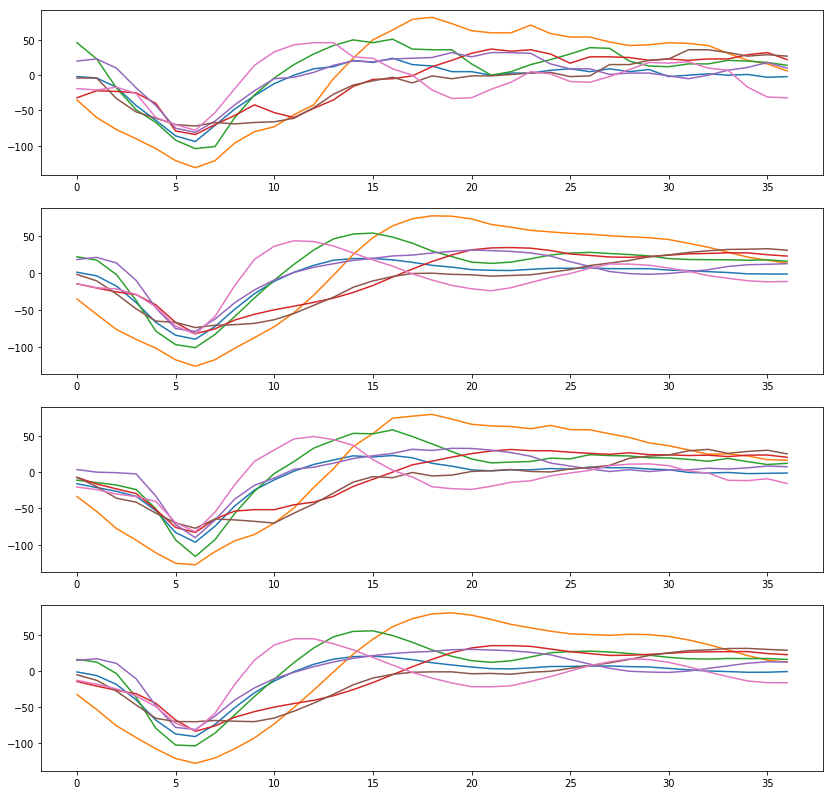

In [36]:
plt.figure(figsize=(14,14))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o = ae_1.forward(data)
    o = (o.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o)))
    enc, o_gan = gen.forward(data)
    o_gan = (o_gan.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_gan)))
    enc, o_lstm = lstm_ae.forward(data)
    o_lstm = (o_lstm.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_lstm)))
    print('-----------------')
    plt.subplot(411)
    plt.plot(electrode_data_test[i, :])
    plt.subplot(412)
    plt.plot(o)
    plt.subplot(413)
    plt.plot(o_gan)
    plt.subplot(414)
    plt.plot(o_lstm)
plt.show()

## Listing all output embeddings for t-SNE